In [1]:
# import necessary libraries
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import re
import spacy
import neuralcoref # https://github.com/huggingface/neuralcoref
from rank_bm25 import BM25Okapi
import networkx as nx # pip install networkx

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# loading spacy model
nlp = spacy.load('en_core_web_md')
neuralcoref.add_to_pipe(nlp)

In [2]:
# function for getting Wikipedia data for a particular topic
def get_wiki_page(name):
    wiki_api = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(page_name))
        return

    page_df = pd.DataFrame({
        'page': page_name,
        'text': page_name.text,
        'link': page_name.fullurl,
        'categories': [[y[9:] for y in list(page_name.categories.keys())]],
        })

    return page_df

# get_wiki_page('Kanye West')

In [3]:
# function for preprocessing text
def preprocess_text(text):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    return text

In [4]:
# function for refining entity pairs
def filter_entities(entity, sentence):
    garbage_tokens = (
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
    )
    
    entity_type = entity.ent_type_  # get entity type
    if entity_type == '':
        entity_type = 'NOUN_CHUNK'
        entity = ' '.join(str(i.text) for i in nlp(str(entity)) if i.pos_ not in garbage_tokens and i.is_stop == False)
    elif entity_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(entity).find(' ') == -1:
        cleaned = ''
        for i in range(len(sentence) - entity.i):
            if entity.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                cleaned += ' ' + str(ent.nbor(i))
            else:
                entity = cleaned.strip()
                break

    return entity, entity_type

In [5]:
# function for extracting entity pairs
def extract_entity_pairs(text, coref = True):
    text = preprocess_text(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    entity_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        nodes = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        nodes = spacy.util.filter_spans(nodes)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(node, attrs={'tag': node.root.tag, 'dep': node.root.dep}) for node in nodes]
        dependencies = [token.dep_ for token in sent]
        
        # limiting to simple sentences with one subject and object
        if (dependencies.count('obj') + dependencies.count('dobj')) != 1\
                or (dependencies.count('subj') + dependencies.count('nsubj')) != 1:
            continue
            
        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  continue # identifying object nodes continue
            subject = [w for w in token.head.lefts if w.dep_ in ('subj', 'nsubj')]  # identifying subject nodes
        
            if subject:
                subject = subject[0]
                # identifying relationship by root dependency
                relationship = [word for word in token.ancestors if word.dep_ == 'ROOT']
                if relationship:
                    relationship = relationship[0]
                    if relationship.nbor(1).pos_ in ('ADP', 'PART'):
                        relationship = ' '.join((str(relationship), str(relationship.nbor(1))))
                else:
                    relationship = 'unknown'

                subject, subject_type = filter_entities(subject, sent)
                token, object_type = filter_entities(token, sent)

                entity_pairs.append([str(subject), str(relationship), str(token), str(subject_type), str(object_type)])
            
    entity_pairs = [sub for sub in entity_pairs if not any(str(entity) == '' for entity in sub)]
    entity_pairs_df = pd.DataFrame(entity_pairs, columns=['subject', 'relation', 'object', 'subject_type', 'object_type'])
    print('Total Entity Pairs Extracted:', str(len(entity_pairs)))

    return entity_pairs_df

### Testing

In [6]:
# input query
query = 'coronavirus'
query = query.title()

data = get_wiki_page(query)

# displaying the first paragraph of the Wikipedia page
first_para = data.loc[0, 'text'].split('\n')[0]
display(first_para)

'Coronaviruses are a group of related RNA viruses that cause diseases in mammals and birds. In humans and birds, they cause respiratory tract infections that can range from mild to lethal. Mild illnesses in humans include some cases of the common cold (which is also caused by other viruses, predominantly rhinoviruses), while more lethal varieties can cause SARS, MERS, and COVID-19. In cows and pigs they cause diarrhea, while in mice they cause hepatitis and encephalomyelitis.'

In [7]:
entity_pairs = extract_entity_pairs(data.loc[0,'text'].replace('"',''))

Total Entity Pairs Extracted: 39


In [8]:
# lemmatizing relations to obtain simple ones
relations = entity_pairs['relation'].to_list()
doc_list = []
relations_simple = []

def get_lemmas(lst):
    for item in lst:
        doc_list.append(nlp(item))
    for text in doc_list:
        if len(text) == 1:
            for token in text:
                relations_simple.append(token.lemma_)
        else:
            relations_simple.append(str(text))


get_lemmas(relations)
entity_pairs['relation_simple'] = relations_simple

# displaying updated dataframe
entity_pairs.head()

,subject,relation,object,subject_type,object_type,relation_simple
0,Dorothy Hamre,isolated,novel,PERSON,NOUN_CHUNK,isolate
1,IBV,had,distinctive club like spikes,ORG,NOUN_CHUNK,have
2,new group,named,morphological appearance,NOUN_CHUNK,NOUN_CHUNK,name
3,coronavirus particle,has,74 surface spikes,NOUN_CHUNK,NOUN_CHUNK,have
4,subgroup,has,shorter spike like surface protein,NOUN_CHUNK,NOUN_CHUNK,have


infect              8
have                8
cause               7
mediate             2
target              2
issue               1
produce             1
share               1
The large number    1
isolate             1
Name: relation_simple, dtype: int64


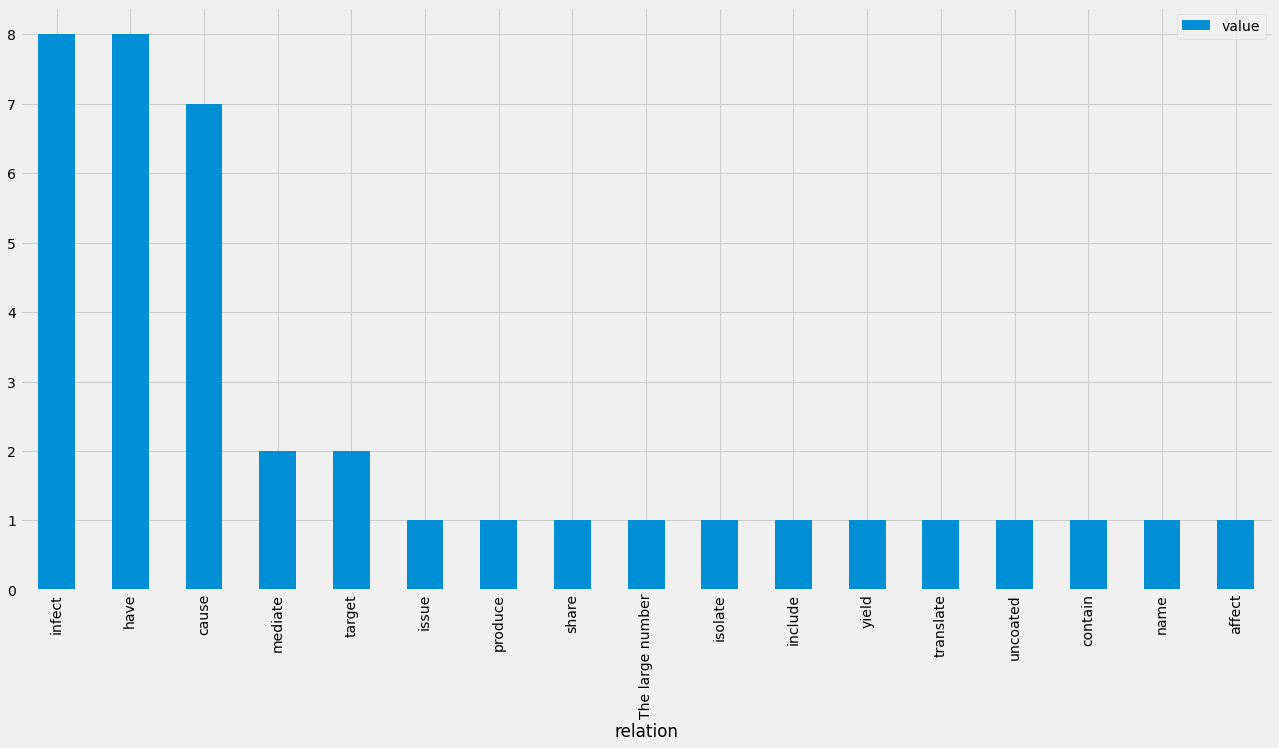

In [9]:
# checking count of each relation
relation_count = entity_pairs['relation_simple'].value_counts()
count_dict = relation_count.to_dict()

relation = list(count_dict.keys())
value = list(count_dict.values())

df_temp = pd.DataFrame({'relation':relation, 'value':value})
ax = df_temp.plot.bar(x = 'relation', y = 'value',figsize=(20,10))

# printing top-10 relations
print(entity_pairs['relation_simple'].value_counts()[:10])

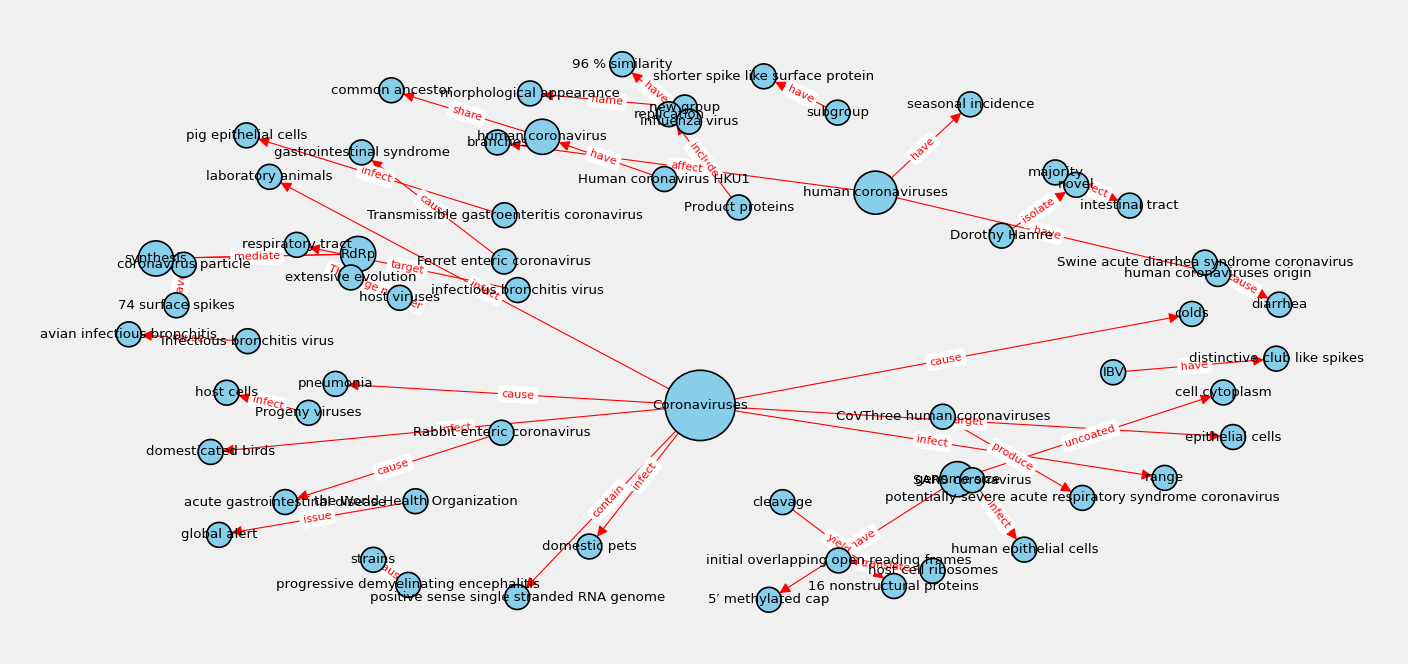

In [10]:
# function to draw the Knowledge Graph
def plot_KG(entity_pairs):
    knowledge_graph = nx.from_pandas_edgelist(entity_pairs, 'subject', 'object', create_using = nx.MultiDiGraph())
    node_degree = nx.degree(knowledge_graph)
    layout = nx.spring_layout(knowledge_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(20, 10), dpi=80)
    
    nx.draw_networkx(
        knowledge_graph,
        node_size=[int(deg[1]) * 500 for deg in node_degree],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='skyblue',
        )
    
    labels = dict(zip(list(zip(entity_pairs.subject, entity_pairs.object)), entity_pairs['relation_simple'].tolist()))
    nx.draw_networkx_edge_labels(knowledge_graph, pos = layout, edge_labels = labels, font_color = 'red')
    plt.axis('off')
    plt.show()
    
plot_KG(entity_pairs)

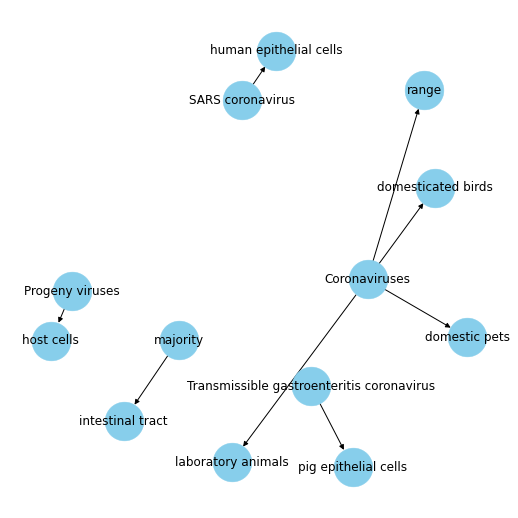

In [11]:
# function for getting Knowledge Graph for a particular relation
def get_relation_KG(relation):
    G=nx.from_pandas_edgelist(entity_pairs[entity_pairs['relation_simple']==relation], "subject", "object", 
                              edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(7,7))
    pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()
    
get_relation_KG('infect')

In [12]:
# getting pairs relation wise
overall=[]
for i in set(relations_simple):
    select_string = entity_pairs[['subject','object']].where(entity_pairs['relation_simple'] == i)
    y = select_string.dropna()
    row_list = []
    
    # iterating over each row 
    for index, rows in y.iterrows(): 
    # creating list for the current row 
        my_list = [rows.subject, rows.object] 
    # append the list to the final list 
        row_list.append(my_list) 

    #print(Row_list)
    x_dict= {i: row_list}
    overall.append(x_dict)
    
display(overall)

[{'share': [['human coronavirus', 'common ancestor']]},
 {'target': [['Coronaviruses', 'epithelial cells'],
   ['infectious bronchitis virus', 'respiratory tract']]},
 {'cause': [['Coronaviruses', 'colds'],
   ['Coronaviruses', 'pneumonia'],
   ['Infectious bronchitis virus', 'avian infectious bronchitis'],
   ['Swine acute diarrhea syndrome coronavirus', 'diarrhea'],
   ['Ferret enteric coronavirus', 'gastrointestinal syndrome'],
   ['strains', 'progressive demyelinating encephalitis'],
   ['Rabbit enteric coronavirus', 'acute gastrointestinal disease']]},
 {'name': [['new group', 'morphological appearance']]},
 {'contain': [['Coronaviruses', 'positive sense single stranded RNA genome']]},
 {'yield': [['cleavage', '16 nonstructural proteins']]},
 {'issue': [['the World Health Organization', 'global alert']]},
 {'uncoated': [['genome size', 'cell cytoplasm']]},
 {'mediate': [['RdRp', 'synthesis'], ['RdRp', 'synthesis']]},
 {'The large number': [['host viruses', 'extensive evolution']]}

In [13]:
# adding a 'sentences' column in our entity pairs dataframe
entity_pairs['sentences'] = entity_pairs['subject'] + ' ' + entity_pairs['relation_simple'] + ' ' + entity_pairs['object'] +'.'
entity_pairs

,subject,relation,object,subject_type,object_type,relation_simple,sentences
0,Dorothy Hamre,isolated,novel,PERSON,NOUN_CHUNK,isolate,Dorothy Hamre isolate novel.
1,IBV,had,distinctive club like spikes,ORG,NOUN_CHUNK,have,IBV have distinctive club like spikes.
2,new group,named,morphological appearance,NOUN_CHUNK,NOUN_CHUNK,name,new group name morphological appearance.
3,coronavirus particle,has,74 surface spikes,NOUN_CHUNK,NOUN_CHUNK,have,coronavirus particle have 74 surface spikes.
4,subgroup,has,shorter spike like surface protein,NOUN_CHUNK,NOUN_CHUNK,have,subgroup have shorter spike like surface protein.
5,Coronaviruses,contain,positive sense single stranded RNA genome,NOUN_CHUNK,NOUN_CHUNK,contain,Coronaviruses contain positive sense single st...
6,genome size,has,5′ methylated cap,NOUN_CHUNK,NOUN_CHUNK,have,genome size have 5′ methylated cap.
7,genome size,uncoated,cell cytoplasm,NOUN_CHUNK,NOUN_CHUNK,uncoated,genome size uncoated cell cytoplasm.
8,host cell ribosomes,translate,initial overlapping open reading frames,NOUN_CHUNK,NOUN_CHUNK,translate,host cell ribosomes translate initial overlapp...
9,cleavage,yields,16 nonstructural proteins,NOUN_CHUNK,NOUN_CHUNK,yield,cleavage yield 16 nonstructural proteins.


In [14]:
# ranking the relations per query
corpus = entity_pairs['sentences']

tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

query = "cause"
tokenized_query = query.split(" ")

# getting top-N
bm25.get_top_n(tokenized_query, corpus, n=5)

['Coronaviruses cause colds.',
 'Coronaviruses cause pneumonia.',
 'strains cause progressive demyelinating encephalitis.',
 'Ferret enteric coronavirus cause gastrointestinal syndrome.',
 'Rabbit enteric coronavirus cause acute gastrointestinal disease.']